In [1]:
# Change directory
%cd /content/drive/MyDrive/Colab Notebooks/Bachelor Thesis/Notebooks/Data

/content/drive/MyDrive/Colab Notebooks/Bachelor Thesis/Notebooks/Data


In [2]:
! sudo apt-get update
! sudo apt-get install texlive-latex-recommended
! sudo apt-get install dvipng texlive-latex-extra texlive-fonts-recommended
! wget http://mirrors.ctan.org/macros/latex/contrib/type1cm.zip
! unzip type1cm.zip -d /tmp/type1cm
! cd /tmp/type1cm/type1cm/ && sudo latex type1cm.ins
! sudo mkdir /usr/share/texmf/tex/latex/type1cm
! sudo cp /tmp/type1cm/type1cm/type1cm.sty /usr/share/texmf/tex/latex/type1cm
! sudo texhash
!apt install cm-super

Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:3 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:5 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Hit:7 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Get:8 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [1,683 kB]
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Get:10 https://r2u.stat.illinois.edu/ubuntu jammy/main all Packages [8,958 kB]
Get:11 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Get:12 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease [24.6 kB]
Get:13 https://r2u.stat.illinois.edu/ubu

In [17]:
cbscolor = (73/255, 103/255, 170/255)

In [3]:
import matplotlib as mpl
mpl.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "text.latex.preamble": r"""
        \usepackage{type1cm}
        \usepackage{amsmath}
    """
})

# Data Profilling & Cleaning

**GOAL**: Get the largest temporally continous timeseries from raw data, by selecting timeframe and features.

## Data Import

We import the raw data queried from WRDS and helper data.

In [4]:
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib.patches import Rectangle
import seaborn as sns
import pandas as pd
import numpy as np

In [5]:
# Read dataset
data_stock_returns = pd.read_parquet("handoffs/data_raw.parquet")

# Import label clusters and details
data_label_clusters = pd.read_csv("https://raw.githubusercontent.com/bkelly-lab/ReplicationCrisis/master/GlobalFactors/Cluster%20Labels.csv")

In [6]:
# Get relevant variables
list_relevant_features = data_label_clusters["characteristic"].tolist()
vars_add = [
    'ret_exc_lead1m',   # excess returns next month
    'id',               # unique security id
    'eom',              # end of month
    'me',               # market equity
    'me_company',       # companies market equity
    'ff49']             # fama & french industries
list_primary_features = list(set(list_relevant_features).union(vars_add[-3:]))
list_relevant_features = list(set(list_relevant_features).union(vars_add))

# Subset relevant features
data_stock_returns = data_stock_returns[list_relevant_features]
data_stock_returns = data_stock_returns.reset_index(drop=True)

Remove unnessecary varibales.

In [7]:
del data_label_clusters, vars_add

## Missingness by date

Overall missingness for each date.

In [8]:
# Convert eom to dates
data_stock_returns['eom'] = pd.to_datetime(data_stock_returns['eom'])

# Find missing percent over time
missing_pct_overall = data_stock_returns[list_primary_features + ['eom']].groupby('eom').apply(
    lambda x: x.isnull().sum().sum() / (x.shape[0] * x.shape[1])
)

<ipython-input-8-d5949c580897>:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  missing_pct_overall = data_stock_returns[list_primary_features + ['eom']].groupby('eom').apply(


Plot the missingness by `eom`.

In [9]:
# Set style OF using DARK MODE
# plt.style.use('dark_background')
# plt.rcParams['figure.facecolor'] = '#383838'
# plt.rcParams['axes.facecolor'] = '#2a2a2a'

# Set style OF using LIGHT MODE
# plt.style.use('default')
# plt.rcParams['figure.facecolor'] = '#FFFFFF'
# plt.rcParams['axes.facecolor'] = '#f1f1f1'

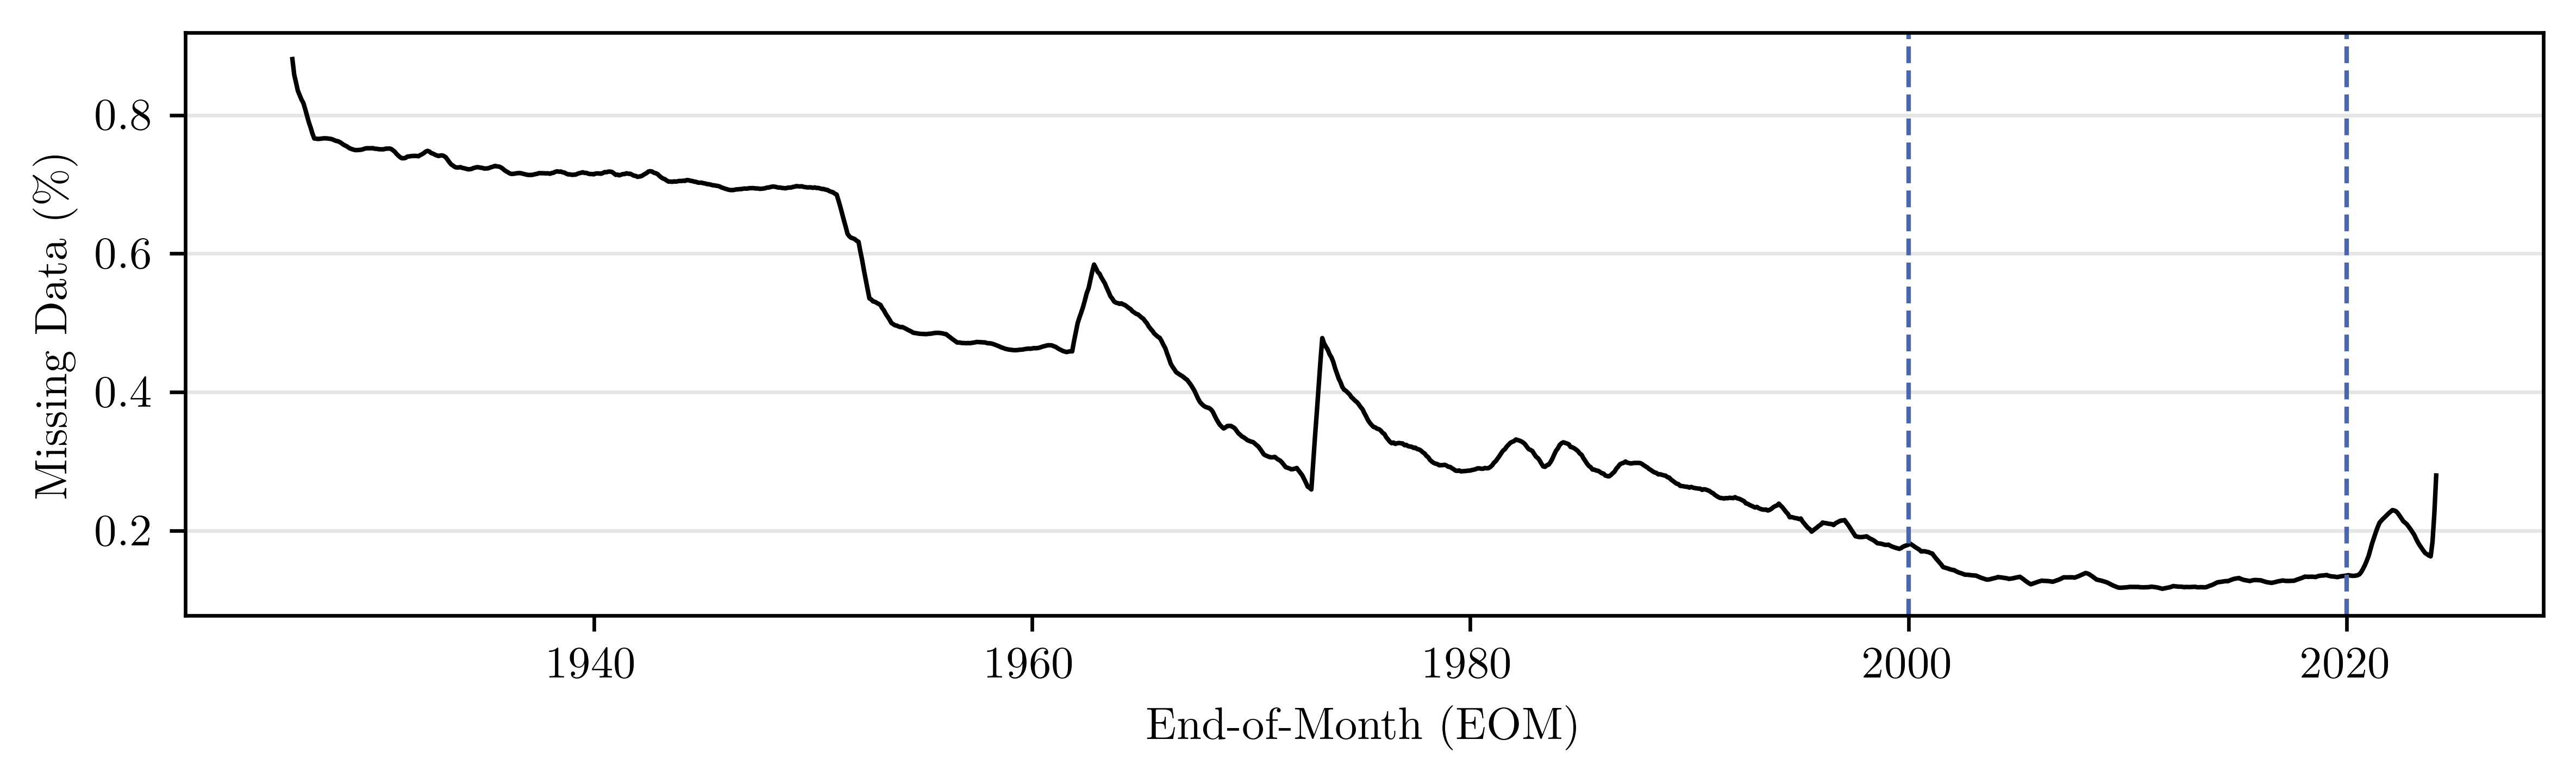

In [22]:
window_size = 6  # You can increase or decrease this number

smoothed_values = missing_pct_overall.rolling(window=window_size, center=True).mean()

plt.figure(figsize=(16*0.5, 5*0.5), dpi=600)
plt.plot(missing_pct_overall.index, smoothed_values, linestyle='-', color='black', linewidth=1)

# Vertical lines remain the same
start = pd.to_datetime('2000-01-01')
end = pd.to_datetime('2019-12-31')

plt.axvline(start, linestyle='--', linewidth=1, color=cbscolor)
plt.axvline(end, linestyle='--', linewidth=1, color=cbscolor)

plt.xlabel('End-of-Month (EOM)')
plt.ylabel('Missing Data (\%)')
plt.grid(axis="y", color="gray", alpha=0.2)
plt.tight_layout()
plt.savefig("missing_data_pct.pdf", dpi=600, bbox_inches="tight")
plt.show()


It is clear that data is missing at the begining and end of period. To simplify we only select data collected between 2000 and 2020.

In [23]:
# Define start and end date
start_date = pd.to_datetime('2000-01-01')
end_date   = pd.to_datetime('2019-12-31')

# Create a mask to filter rows on date range
mask = (data_stock_returns['eom'] >= start_date) & (data_stock_returns['eom'] <= end_date)

# Subset dataframe
data_stock_returns = data_stock_returns.loc[mask]

A basis timeframe is now determined: 2000 to 2020. The next level of granularity is features.

In [24]:
# Remove variables for RAM + Memory
del missing_pct_overall, mask, end_date, start_date

## Missingnes by Features

Find the amount of missing variables for each feature.

In [25]:
missing_pct_feature = data_stock_returns[list_primary_features].isnull().sum() / len(data_stock_returns)

Plot missingness by feature.

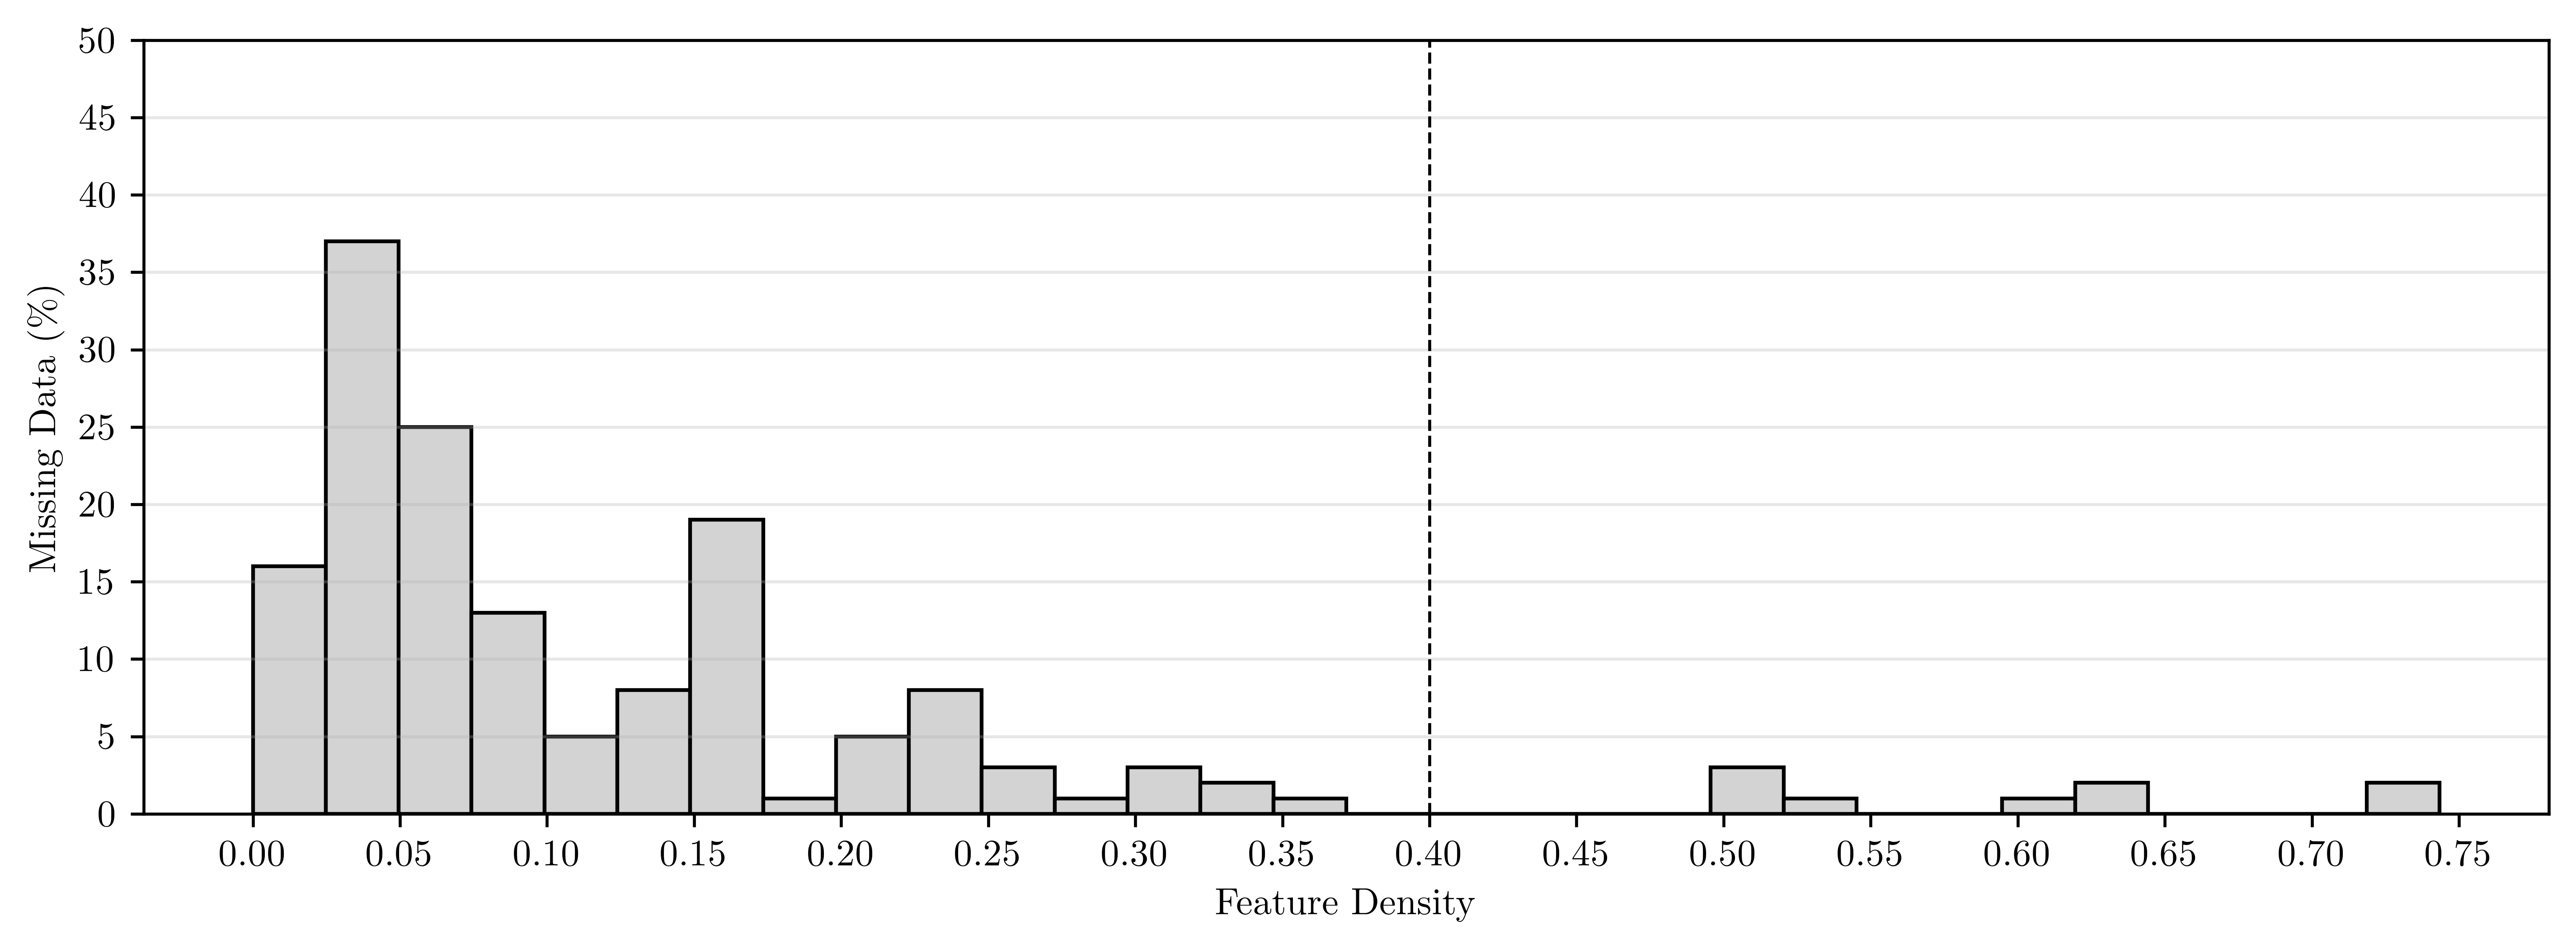

In [29]:
plt.figure(figsize=(16*0.6, 6*0.6), dpi=600)

plt.hist(missing_pct_feature, bins=30, color="lightgray", edgecolor="black")
plt.xticks(np.linspace(0, 0.75, 16))
plt.yticks(np.linspace(0,50,11))


plt.axvline(0.4,   linestyle='--', linewidth=.8, color = "black")
plt.xlabel('Feature Density')
plt.ylabel('Missing Data (\%)')

plt.grid(True, axis='y', linestyle='-', alpha=0.3)
plt.tight_layout()
plt.savefig("missing_data_features_hist.pdf", dpi=600, bbox_inches="tight")

plt.show()

The columns in question.

In [30]:
print(missing_pct_feature[missing_pct_feature>0.4])

rd_me           0.507391
seas_11_15an    0.635114
rd_sale         0.524360
seas_6_10an     0.497104
seas_16_20an    0.740310
seas_16_20na    0.743397
seas_6_10na     0.500851
seas_11_15na    0.638222
rd5_at          0.612941
dtype: float64


We drop these columns.

In [31]:
list_primary_features = [feat for feat in list_primary_features if feat not in missing_pct_feature[missing_pct_feature>0.4]]

In [32]:
data_stock_returns = data_stock_returns.drop(columns=missing_pct_feature[missing_pct_feature>0.4].index)

Remove unnecessary variables

In [33]:
del missing_pct_feature

## Security coverage

We now look at missingness by security.

Securities have different timespans. Missingness is thus defined as total missing data divided by total possible data (observations per stock times number of features).

In [34]:
# Observations for each stock
total_possible = (data_stock_returns      # data
                  .groupby('id')          # group by security
                  .size()                 # count observations
                  .rename('n_months')     # label correctly
                  .to_frame())            # save as frame

# Total possible observations for each stock
total_possible['total_cells'] = (
    total_possible['n_months'] * len(list_primary_features)) # calculate total possible

# Missing data for each stock
missing_count_securities = (data_stock_returns                        # data
                            .groupby('id')[list_primary_features]     # group by security and take primary values
                            .apply(lambda df: df.isna().sum().sum())  # sum missing values in submatrix
                            .rename('missing_cells')                  # label corroctly
                            .to_frame())                              # save as frame

Frames are joined and the missing percent is calculated.

In [35]:
missing_pct_security = (
    total_possible                                                      # data
    .join(missing_count_securities, how='left')                         # left join
    .assign(
      missing_cells = lambda x: x['missing_cells'].fillna(0),           # enure vals in missing_cells
      pct_missing = lambda x: x['missing_cells'] / x['total_cells'])    # calculate pct missing
    .sort_values('pct_missing', ascending=False))                       # sort by missingness

Below is a plot of security coverage and missingness.

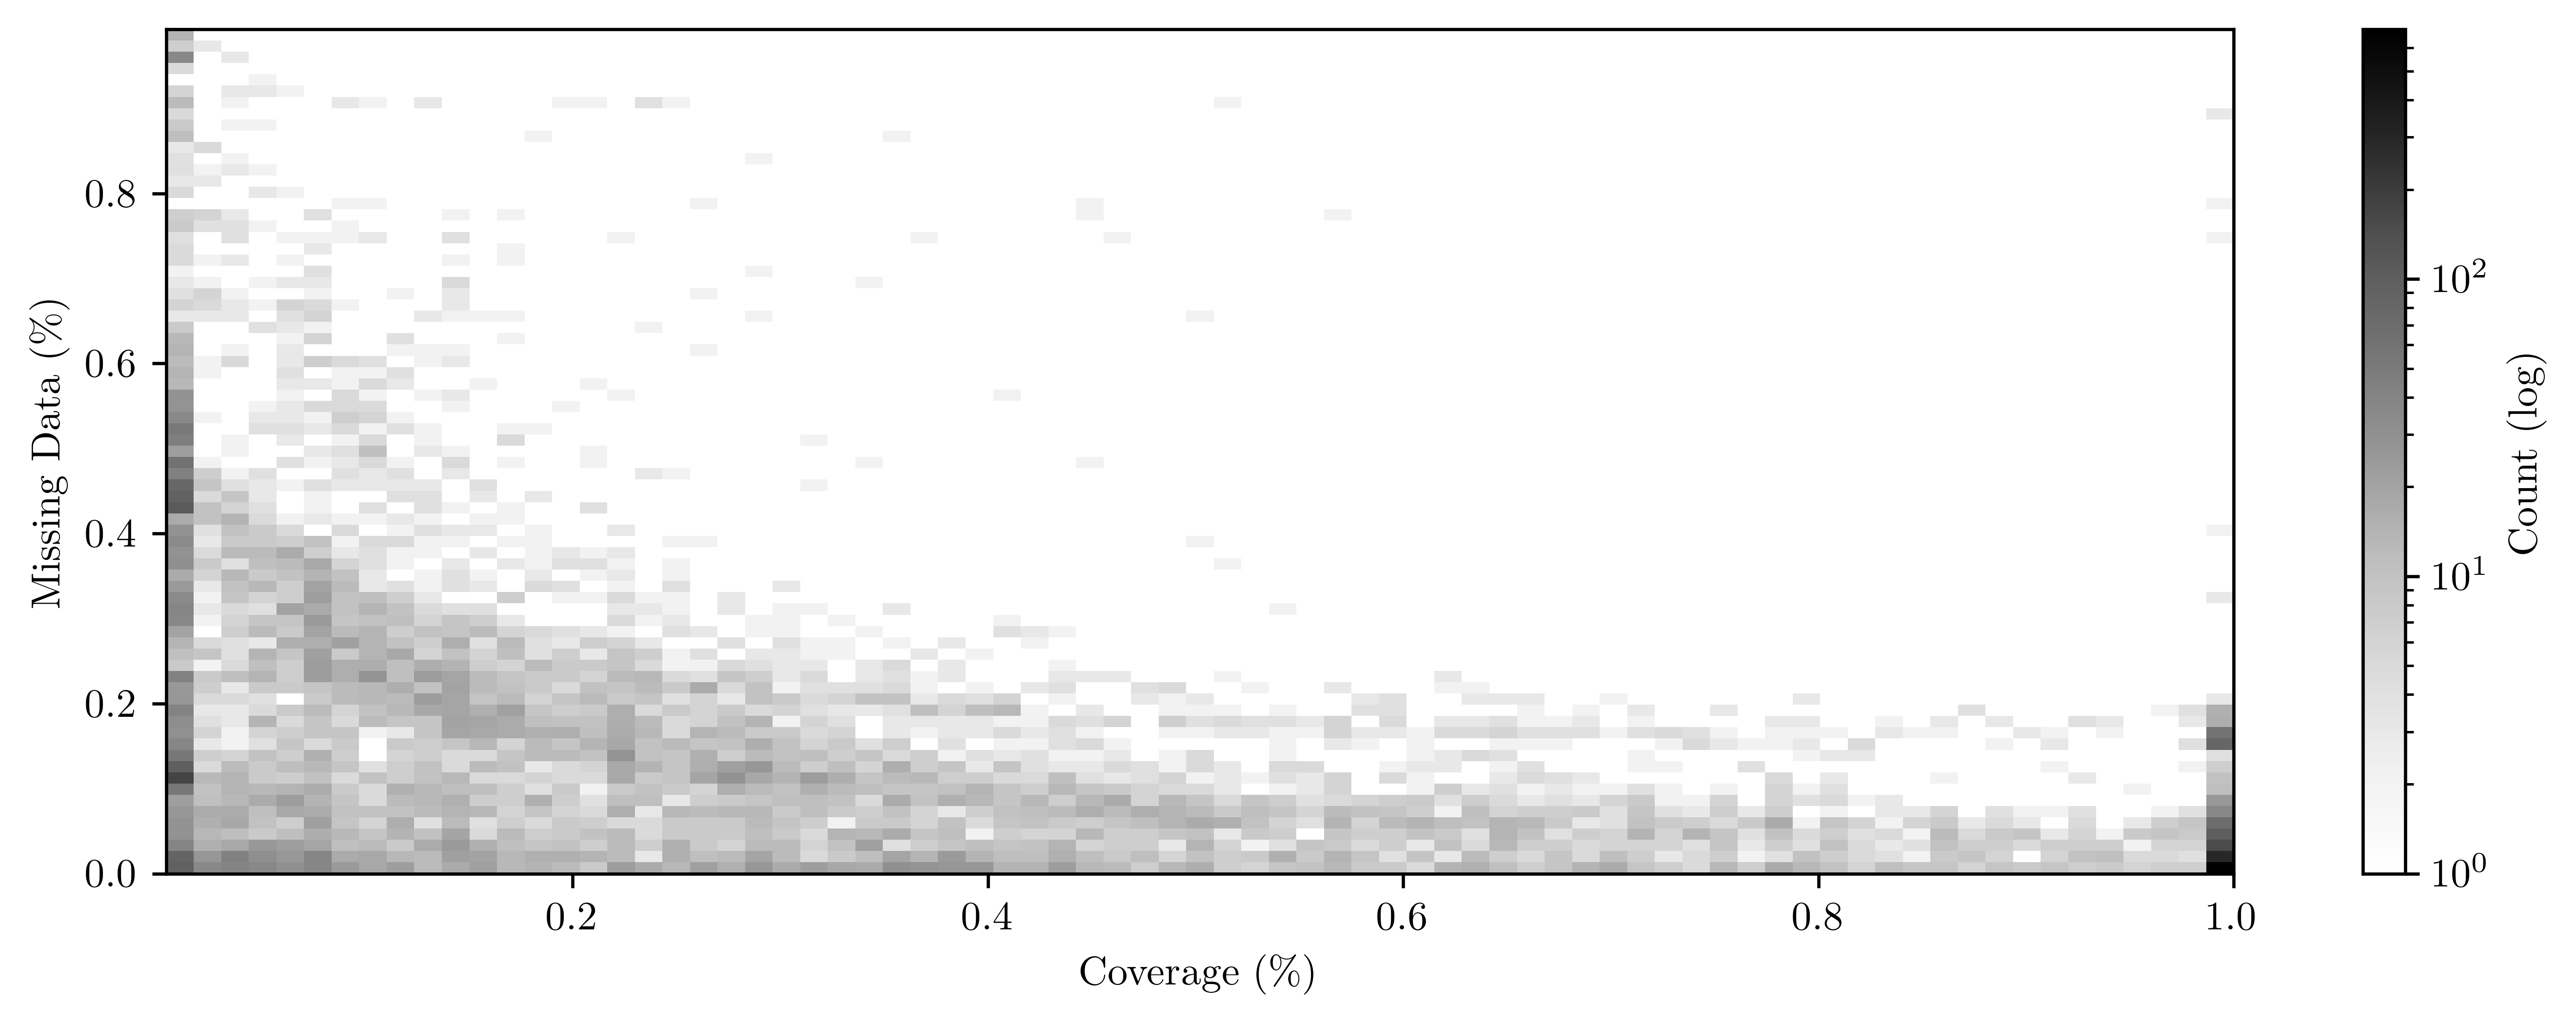

In [39]:
# Create 2d histogram
plt.figure(figsize=(16*0.6, 6*0.6), dpi=600)
h2d = plt.hist2d(
    x=(missing_pct_security['n_months']/
       data_stock_returns['eom'].nunique()),
    y=missing_pct_security['pct_missing'],
    bins=[75, 75],
    norm=LogNorm(vmin=1),
    cmap='Greys'
)

# Add colorbar
cb = plt.colorbar(h2d[3], label='Count (log)')


# Add annotation
n_securities = missing_pct_security[
    (missing_pct_security['n_months']>=240) &
    (missing_pct_security['pct_missing']<0.025)].shape[0]


# Titles
plt.xlabel("Coverage (\%)")
plt.ylabel("Missing Data (\%)")


# Show
plt.tight_layout()
plt.savefig("coverage_missingness.pdf", dpi=600, bbox_inches="tight")
plt.show()

Heatmap shows coverage percent of timeframe (2000-2020) on the x-axis, and proportion of missing data on the y-axis (calculation defined above)

Since we need to fit recurrent neural networks we cannot have parital data. In order to get a rectangular dataset, we have to have full coverage for all stocks.

In [ ]:
# Get stock ids in range
list_stock_in_range_id = missing_pct_security[(missing_pct_security['n_months']>=240) & (missing_pct_security['pct_missing']<0.025)].index

# Subset dataset to only include these stocks
data_stock_returns = data_stock_returns[data_stock_returns['id'].isin(list_stock_in_range_id)]

Remove unnessecary variables.

In [ ]:
del list_stock_in_range_id, missing_count_securities, missing_pct_security, n_securities, total_possible

In [ ]:
data_stock_returns.shape

(225120, 150)

## Imputation

With this few missing values we can imputate the rest. We are imputing approximately 1% of the missing values.

In [ ]:
# Missing pct. dataset
((data_stock_returns[list_primary_features].isnull().sum().sum())
/(data_stock_returns[list_primary_features].size))

np.float64(0.009380242857626349)

We have the following imputation strategy: Forward fill. If the initial value is missing then set to cross sectional median.

Whilst not perfect in theory, due to small amount of missingness this is considered acceptable and heuristic approach to the problem.

This is carried out below.

In [ ]:
def ffill_crm(data, features):
  """
  Forward fill with initial cross-sectional median imputation (in case of
  initial missing).

  Parameters:
  - data: the dataset to by modified.
  - features: the list of features to be modified.
  """

  # Sort in place
  data = data.sort_values(['id', 'eom'])
  data = data.set_index('id')

  # Imputation
  for feature in features:

    def set_initial_median(group):
      if pd.isna(group[feature].iloc[0]):
        median = data[data['eom'] == group['eom'].iloc[0]][feature].median()
        group.iloc[0, group.columns.get_loc(feature)] = median
      return group

    data = data.groupby(level='id', group_keys=False).apply(set_initial_median)
    data[feature] = data.groupby(level='id')[feature].ffill()

  return data.reset_index()

In [ ]:
data_stock_returns = ffill_crm(data_stock_returns, list_primary_features)

Now missingness in data is cleaned. As a final check, we re-calculate missingness in all variables in the dataset.

In [ ]:
remaining_missingness = data_stock_returns.isnull().sum()
remaining_missingness[remaining_missingness > 0]

,0
ret_exc_lead1m,1


We have a few missing returns. The distribution across securities is found.

In [ ]:
data_stock_returns[data_stock_returns['ret_exc_lead1m'].isnull()]['id'].nunique()

1

175 missing values are distributed across 171 securities (no one security is missing a lot of return data). As proscribed in the [Machine Learning for Factor Investing](https://www.mlfactor.com/Data.html) book missing labels (returns) are best handled by setting them to 0. This is therefore done.

In [ ]:
# Imputate 0 in label
data_stock_returns['ret_exc_lead1m'] = data_stock_returns['ret_exc_lead1m'].fillna(0)

# Verify
data_stock_returns.isnull().sum()[data_stock_returns.isnull().sum() > 0]

,0


Data is fully cleaned for missing values, and is saved for further pre-processing (outlier-handling and scaling).

In [ ]:
# Save file
data_stock_returns.to_parquet("/content/drive/MyDrive/Colab Notebooks/Bachelor Thesis/Notebooks/Data/handoffs/data_stock_returns_cleaned.parquet", index=False)